In [1]:
import time, copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.special import comb

In [2]:
def gauss(x, b=0, c=1):
    return np.exp(-(x-b)**2/(2*c**2))

def gauss_kx(x, kx, b=0, c=1):
    return gauss(x, b, c) * np.exp(1j * kx * x)

def get_BC_kx(x_0, x_max, x_step, kx, beam_center=0, waist=1):
    BC = [gauss_kx(x, kx, beam_center, waist) for x in np.arange(x_0, x_max, x_step)]
    return np.array(BC)

In [3]:
def n_to_Veff(n_of_x, k):
    return 0.5 * k * (np.array(n_of_x)**2 - 1)

In [17]:
def n_sqr_well(x, x_star=2.5):
    coef = np.power(0.005, 1/4) / x_star
    if np.abs(x) <= x_star:
        val = 1 + (coef * x)**4
    else:
        val = 1.005
    return val

def n_step0(x, a=1):
    return 0.25 * np.tanh(a*x) + 1.25

def n_step1(x, a=1):
    return 0.25 * np.tanh(-a*x) + 1.25

def n_step_sharp0(x, midpoint=0):
    if x < midpoint:
        return 1
    else:
        return 1.5
    
def n_step_sharp1(x, midpoint=0):
    if x > midpoint:
        return 1
    else:
        return 1.5

def dEdz_vec(E, x, k, n_of_x, ddx):
    V_eff = n_to_Veff(n_of_x, k)
    return (((-V_eff * E) - ddx/(2*k)) / 1j)

def RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_of_x, dvals=False):
    # list of zvals
    z_list = np.arange(z_0, z_max, z_step)
    
    # list of xvals
    x_list = np.arange(x_0, x_max, x_step)
    
    # if we want to see the 2nd derivative
    if dvals:
        d_grid = [np.gradient(np.gradient(BC, x_step, edge_order=1), x_step, edge_order=1)]
    
    # grid of E vals starts as just the boundary conditions
    E_grid = [BC]
    
    # beam power
    p0 = np.sum(np.abs(BC))
    
    # loop over z's
    for i in tqdm(range(int((z_max - z_0) / z_step))):
        # 1st derivative
        der_1 = np.gradient(E_grid[i], x_step, edge_order=1)
        
        # 2nd derivative
        der_vals = np.gradient(der_1, x_step, edge_order=1)
        if dvals:
            d_grid.append(der_vals)
        
        k1_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals)
        k2_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + 0.5 * k1_vec)
        k3_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + 0.5 * k2_vec)
        k4_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + k3_vec)
        
        new_slice = E_grid[i] + k1_vec/6 + k2_vec/3 + k3_vec/3 + k4_vec/6
        
#         save old slices as 16 bit float
        if i >= 1:
            E_grid[i-1] = np.float16(np.abs(E_grid[i-1]))
        
        new_pwr = np.sum(np.abs(new_slice))
        
        if new_pwr / p0 > 2:
            print("power not conserved")
            print(f"inital power:{p0}, new power:{new_pwr}")
            print(f"step:{i}, distance:{i*z_step} (microns)")
            break

        E_grid.append(new_slice)
    
    # save last slice as 16 bit float
    E_grid[-1] = np.float16(np.abs(E_grid[-1]))
    
    if dvals:
        return np.abs(d_grid)
    else:
        return np.array(np.abs(E_grid), dtype=np.float16)

In [5]:
def get_angle(k, kx):
    return np.arcsin(kx / k)

def get_kz(k, angle):
    return np.cos(angle) * k

In [59]:
# physical params
lam0 = 200 * 10**(-3) # micrometers
# lam = 200 * 10**(-9) # meters
k0 = 2*np.pi/lam0

lam1 = lam0 / 1.5
k1 = 2*np.pi/lam1

# beam params (micrometers)
beam_center = -2.5
waist = 1

# spatial params (micrometers)
x_step = 1*10**(-1)
x_0 = -6
x_max = 6

z_step = 1*10**(-5)
z_0 = 0
z_max = 5*10**(1)
hlim = z_max / z_step

kxs = np.arange(0, 1, 0.02)

angles = get_angle(k0, kxs)
kzs0 = get_kz(k0, angles)
kzs1 = get_kz(k1, angles)

x_list = np.arange(x_0, x_max, x_step)


# 30 - 50 degrees
large_angles = -np.arange(30*np.pi/180, 60*np.pi/180, 10*np.pi/180)
large_kxs = [np.sin(angle) * k0 for angle in large_angles]
large_kzs = [np.cos(angle) * k0 for angle in large_angles]

In [46]:
big_angle = 30 * np.pi / 180
big_kx0 = np.sin(big_angle) * k0
big_kz0 = np.cos(big_angle) * k0

big_kx1 = np.sin(big_angle) * k1
big_kz1 = np.cos(big_angle) * k1

In [47]:
def linear_n(x):
    return 1.06 + (z_step / x_step) * x

n_lin = [linear_n(x) for x in x_list]

# plt.plot(n_lin)
# n lists
n_well_list = np.array([n_sqr_well(x) for x in x_list])
n_free = [1 for x in x_list]
n_glass0 = n_step0(x_list, a=2)
n_glass_sharp0 = [n_step_sharp0(x) for x in x_list]

n_glass1 = n_step1(x_list, a=2)
n_glass_sharp1 = [n_step_sharp1(x) for x in x_list]

s_val = 25
p_val = 7
ss_val = 5
# n_smooth = savgol_filter(n_well_list, s_val, p_val)
# n_ss = uniform_filter1d(n_smooth, ss_val)

In [16]:
# plt.plot(n_well_list)
# plt.plot(n_free)
# plt.plot(n_glass1)
# plt.plot(n_glass_sharp)

In [17]:
# kxs, kzs

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:16<00:00, 7324.68it/s]
C:\Users\Owner\AppData\Local\Temp\ipykernel_9912\2790064691.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(E_grid, dtype=np.float16)


wavenumber (um^(-1)): 0.0


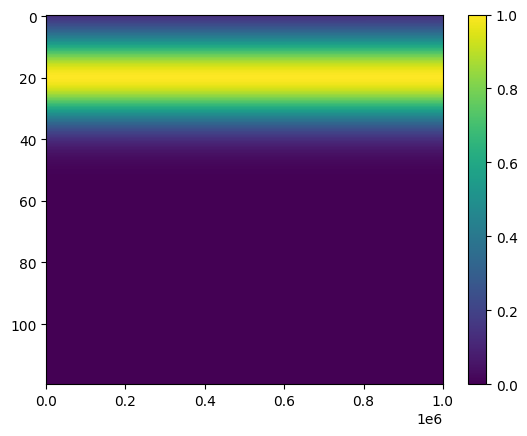

In [16]:
# very slowly changing n, angle = 0
# e grid
idx = 0

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_lin, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

In [19]:
# # very slowly changing n, angle = 0
# # abs(2nd derivative)
# idx = 0

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_lin, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:13<00:00, 7517.15it/s]


wavenumber (um^(-1)): 0.0


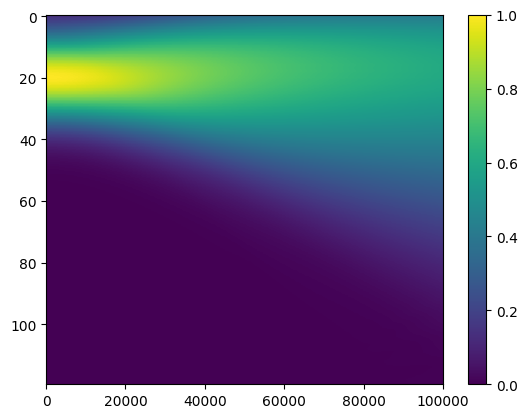

In [33]:
# uniform index of refraction n=1, no angle
# e grid
idx = 0

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_free, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(E_grid0.T, aspect="auto")

plt.colorbar()

In [21]:
# # uniform index of refraction n=1, no angle
# # abs(2nd derivative)
# idx = 0

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_free, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7512.34it/s]


wavenumber (um^(-1)): 0.98


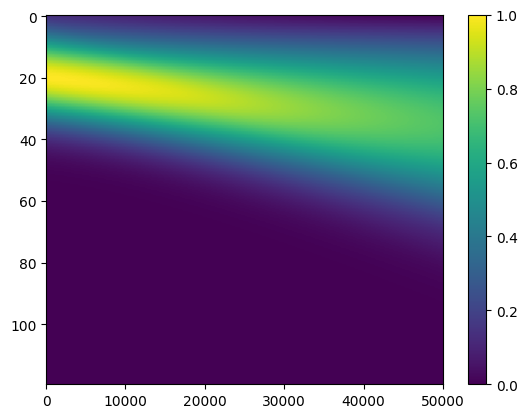

In [38]:
# n = 1, angle = 0.031
# e grid

idx = -1

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_free, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

In [23]:
# # n = 1, angle = 0.031
# # abs(2nd derivative)

# idx = -1

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_free, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [08:21<00:00, 9963.71it/s]


wavenumber (um^(-1)): 0.0


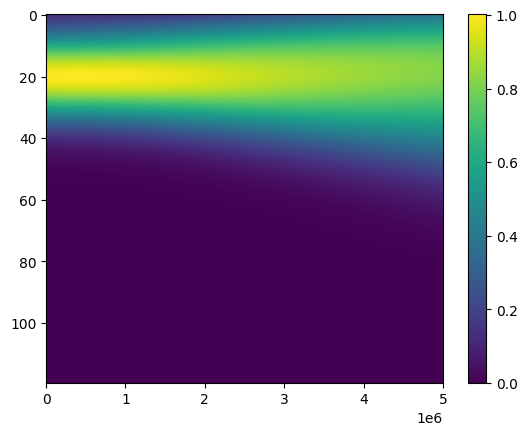

In [43]:
# n = 1.5, angle = 0
# does not conserve power unless z_step ~>=10^-5
idx = 0

kx = kxs[idx]
kz = kzs1[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, 1.5, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:59<00:00, 8336.12it/s]


wavenumber (um^(-1)): 0.0


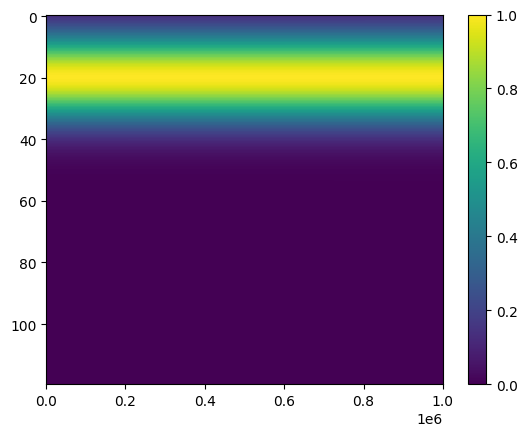

In [25]:
# air to glass, angle = 0
# e grid
idx = 0

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass0, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

In [26]:
# # air to glass, angle = 0
# # abs(2nd derivative)
# idx = 0

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass0, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

In [27]:
# plt.plot(n_glass0)

In [28]:
# # air to glass, angle = 0 n_glass_sharp
# # e grid

# idx = 0

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass_sharp0, False)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

In [29]:
# # air to glass, angle = 0 n_glass_sqr
# # abs(2nd derivative)
# idx = 0

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass_sharp0, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [09:52<00:00, 8442.24it/s]


wavenumber (um^(-1)): 0.98


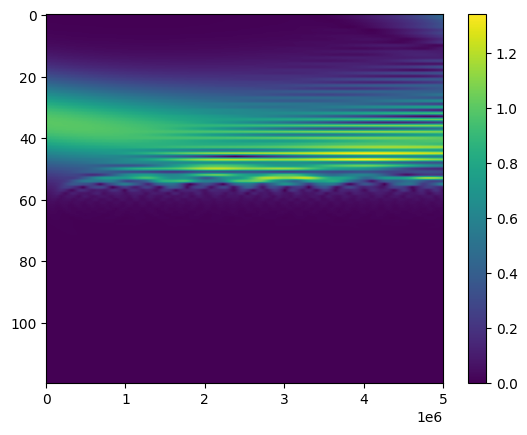

In [48]:
# air to glass, angle = 0.031
# e grid

idx = -1

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass0, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [10:00<00:00, 8325.53it/s]


wavenumber (um^(-1)): -24.065995948258653


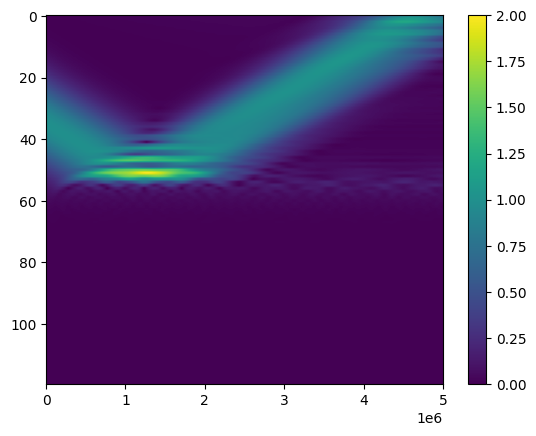

In [60]:
# air to glass, angle = 0.8726646259971648 = 50 deg
# e grid

idx = -1

kx = large_kxs[idx]
kz = large_kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass0, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

Text(0, 0.5, 'n')

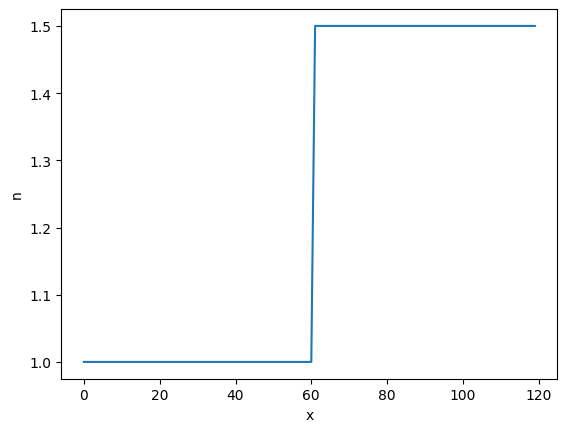

In [71]:
plt.plot(n_glass_sharp0)
plt.xlabel("x")
plt.ylabel("n")

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [11:49<00:00, 7042.26it/s]


wavenumber (um^(-1)): -24.065995948258653


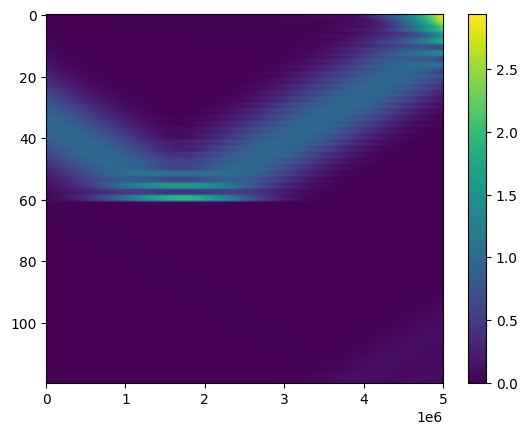

In [69]:
# air to glass, angle = 0.8726646259971648 = 50 deg
# e grid

idx = -1

kx = large_kxs[idx]
kz = large_kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass_sharp0, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

 84%|██████████████████████████████████████████████████████████▉           | 4213702/5000000 [08:24<01:34, 8355.60it/s]


power not conserved
inital power:25.06148164202809, new power:50.12300990714736
step:4213702, distance:42.13702000000001 (microns)
wavenumber (um^(-1)): -24.065995948258653


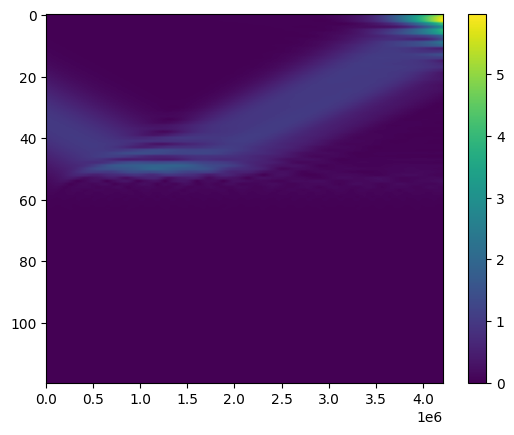

In [61]:
# glass to air, angle = 0.8726646259971648 = 50 deg
# e grid

idx = -1

kx = large_kxs[idx]
kz = large_kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass1, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

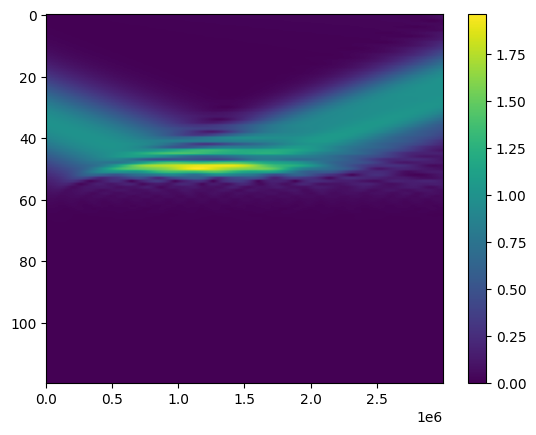

In [63]:
plt.imshow(np.abs(E_grid0[:3*10**6].T), aspect="auto")

plt.colorbar()

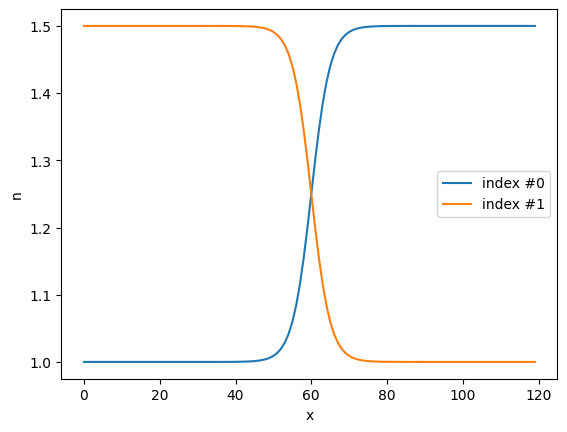

In [66]:
plt.plot(n_glass0, label="index #0")
plt.plot(n_glass1, label="index #1")
plt.xlabel("x")
plt.ylabel("n")
plt.legend()

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [09:53<00:00, 8419.00it/s]


wavenumber (um^(-1)): 0.98


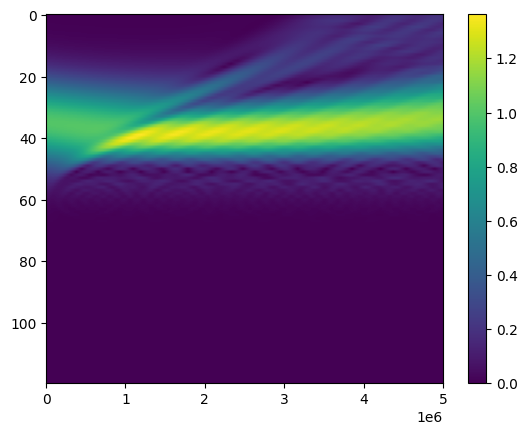

In [52]:
# glass to air, angle = 0.031
# e grid

idx = -1

kx = kxs[idx]
kz = kzs0[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass1, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

In [31]:
# # air to glass, angle = 0.031
# # abs(2nd derivative)

# idx = -1

# kx = kxs[idx]
# kz = kzs0[idx]

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass0, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [09:26<00:00, 8827.84it/s]


wavenumber (um^(-1)): 15.707963267948964


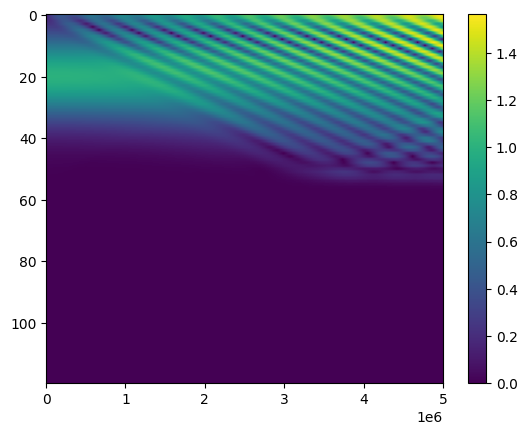

In [44]:
# air to glass, angle = 0.523 rad
# e grid

kx = big_kx0
kz = big_kz0

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass0, False)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

In [39]:
# # air to glass, angle = 0.523 rad
# # abs(2nd derivative)

# kx = big_kx0
# kz = big_kz0

# # make boundary condition
# BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# # calculate propagation
# E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_free, True)

# print(f"wavenumber (um^(-1)): {kx}")

# plt.imshow(np.abs(E_grid0.T), aspect="auto")

# plt.colorbar()

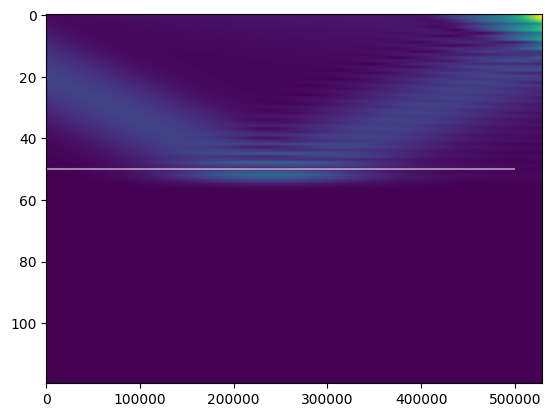

In [165]:
plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.hlines(50, 0, 0.5*z_max / z_step, color="white", alpha=0.5)

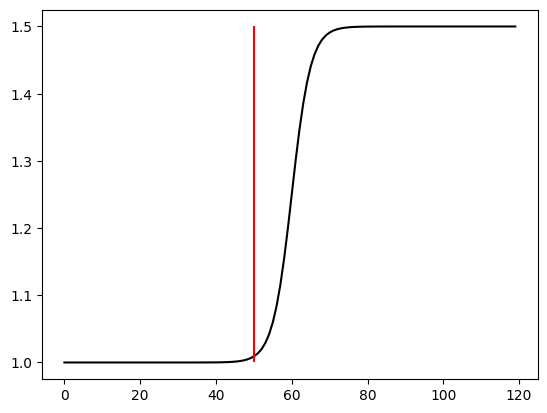

In [166]:
plt.plot(n_glass0, c="0")
plt.vlines(50, 1, 1.5, color="r")

  4%|███▎                                                                      | 4405/100000 [00:00<00:11, 8046.11it/s]

power not conserved
inital power:49.05858290737028, new power:98.1172113768574
step:4405, distance:4.405
wavenumber (um^(-1)): 15.707963267948964


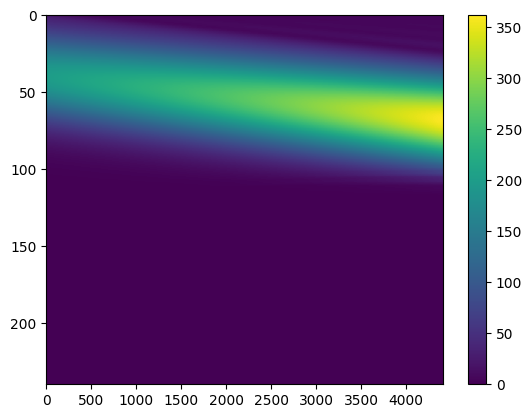

In [149]:
# air to glass, angle = 0.174
# doesnt work

kx = big_kx0
kz = big_kz0

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, k0, n_glass1, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

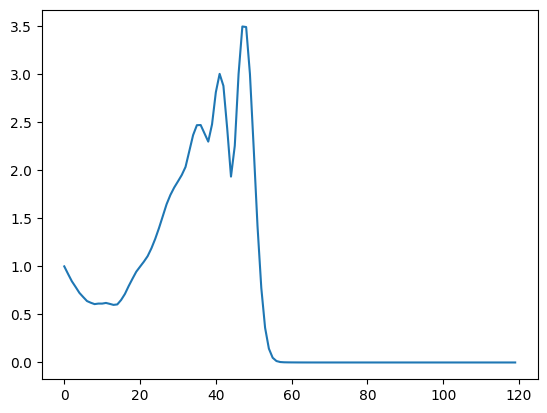

In [179]:
pwr = [np.sum(np.abs(E_grid0.T[i])) for i in range(len(E_grid0.T))]
plt.plot(pwr / np.sum(np.abs(E_grid0.T[0])))

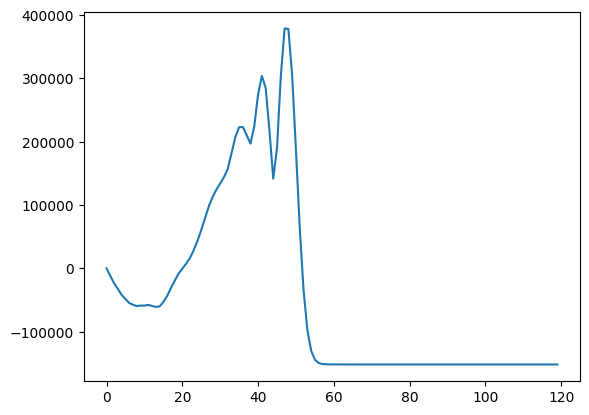

In [181]:
plt.plot(pwr - np.sum(np.abs(E_grid0.T[0])))

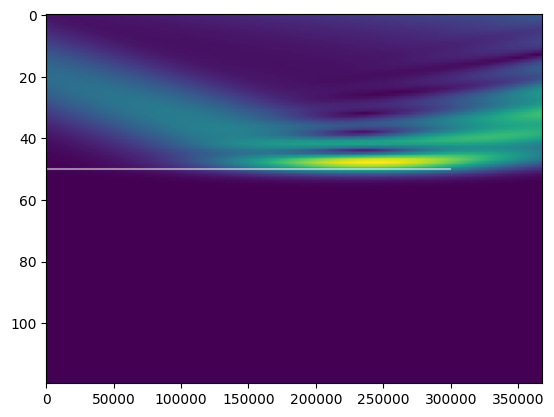

In [170]:
plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.hlines(50, 0, 0.3*z_max / z_step, color="white", alpha=0.5)

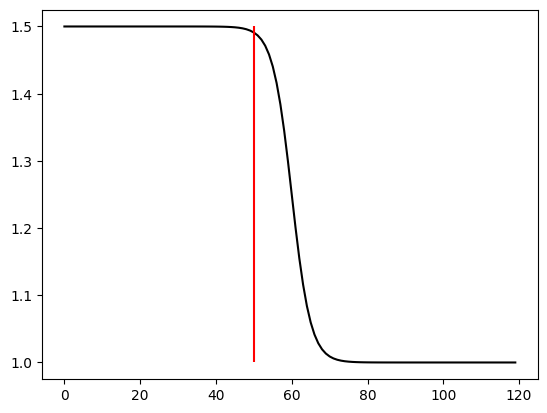

In [171]:
plt.plot(n_glass1, c="0")
plt.vlines(50, 1, 1.5, color="r")

In [191]:
big_angle * 180 / np.pi

10.0